<a href="https://colab.research.google.com/github/erfanghobadian/imagined-speech-classification/blob/main/Imagined_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [1]:
!pip3 install mne
!pip3 install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 84.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.8 MB/s eta 0:00:00


# Imports

In [2]:
from google.colab import drive
import glob
import mne
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from pyts.image import RecurrencePlot
from sklearn.metrics import cohen_kappa_score, recall_score, balanced_accuracy_score


# Variables

In [3]:
drive.mount('/content/drive', force_remount=True)

subjects = [
    "MM05",
    "MM08",
    "MM09",
    "MM10",
    "MM11",
    "MM12",
    "MM14",
    "MM15",
    "MM16",
    "MM18",
    "MM19",
    "MM20",
    "MM21",
    "P02"
]
drop_ch = (['M1', 'M2', 'EKG', 'EMG', 'Trigger', "VEO", "HEO"])
channels = [
    'FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4',
     'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8',
      'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3',
       'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ',
        'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8',
         'CB1', 'O1', 'OZ', 'O2', 'CB2'
]


BASE_PATH = f"drive/Shareddrives/Drive/BCI/p/spoclab/users/szhao/EEG/data/"

Mounted at /content/drive


# Loading Data

In [12]:
all_labels = np.load("drive/Shareddrives/Drive/BCI/ALL_TRIALS_LABELS_FULL.npy")
all_trials = np.load("drive/Shareddrives/Drive/BCI/ALL_TRIALS_FULL.npz", mmap_mode='r')["arr_0"]

# Utils

In [5]:
def std(x_train, x_test, x_val):
    mean = x_train.mean(axis=0)
    std_val = x_train.std(axis=0)
    x_train_std = (x_train - mean) / std_val
    x_test_std = (x_test - mean) / std_val
    x_val_std = (x_val - mean) / std_val
    return x_train_std, x_test_std, x_val_std


def fft(epoch):
    nfft = epoch.shape[1]
    freq = np.empty(1, dtype=int)
    freq[0] = int(nfft / 2)
    fft_res = np.fft.fft(epoch, n=nfft)
    fft_abs = np.abs(fft_res[:, :freq[0]])
    x = fft_abs * fft_abs
    x[x == 0] = 0.00001
    y = 20 * np.log(x)
    return y


def cov(epoch):
    c = np.cov(epoch)
    return c


def EEGNet(nb_classes, Chans=62, Samples=250,
           dropoutRate=0.5, kernLength=64, F1=8,
           D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1 = tf.keras.layers.Input(shape=(Chans, Samples, 1))

    ##################################################################
    block1 = tf.keras.layers.Conv2D(F1, (1, kernLength), padding='same',
                                    input_shape=(Chans, Samples, 1),
                                    use_bias=False)(input1)
    block1 = tf.keras.layers.BatchNormalization()(block1)
    block1 = tf.keras.layers.DepthwiseConv2D((Chans, 1), use_bias=False,
                                             depth_multiplier=D,
                                             depthwise_constraint=tf.keras.constraints.max_norm(1.))(block1)
    block1 = tf.keras.layers.BatchNormalization()(block1)
    block1 = tf.keras.layers.Activation('elu')(block1)
    block1 = tf.keras.layers.AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    block2 = tf.keras.layers.SeparableConv2D(F2, (1, 16),
                                             use_bias=False, padding='same')(block1)
    block2 = tf.keras.layers.BatchNormalization()(block2)
    block2 = tf.keras.layers.Activation('elu')(block2)
    block2 = tf.keras.layers.AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    flatten = tf.keras.layers.Flatten(name='flatten')(block2)

    dense = tf.keras.layers.Dense(nb_classes, name='dense',
                                  kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(flatten)
    softmax = tf.keras.layers.Activation('softmax', name='softmax')(dense)

    return tf.keras.models.Model(inputs=input1, outputs=softmax)

# Data Extractor

In [6]:
class DataExtractor:

    def apply_notch_filter(self, data):
        data.notch_filter(np.array((60, 120, 180, 240)))
        return data

    def get_indexes(self, subject):
        path = f"{BASE_PATH}/{subject}/epoch_inds.mat"
        f = glob.glob(path)[0]
        epoch_inds = sio.loadmat(f, variable_names=('thinking_inds'))["thinking_inds"][0]
        return epoch_inds

    def extract_raw_data(self, subject):
        path = f"{BASE_PATH}/{subject}/*.cnt"
        f = glob.glob(path)[0]
        raw = mne.io.read_raw_cnt(f, eog=['VEO', 'HEO'], ecg=['EKG'], emg=['EMG'], preload=True)
        return raw

    def extract_labels(self, subject):
        path = f"{BASE_PATH}/{subject}/all_features_simple.mat"
        f = glob.glob(path)[0]
        prompts_to_extract = sio.loadmat(f)
        prompts = prompts_to_extract['all_features'][0, 0]["prompts"][0]
        return prompts

    def get_trials(self, raw, epoch_inds):
        raw = self.apply_notch_filter(raw)
        raw.drop_channels(self.drop_ch)
        print(raw.info)
        print(raw.info.ch_names)
        print(1/0)
        raw_data = raw.get_data()
        res = np.empty((epoch_inds.shape[0], raw_data.shape[0], 4000))
        for i, t in enumerate(epoch_inds):
            epoch = raw_data[:, t[0][0] + 500:t[0][0] + 4500]
            res[i] = epoch
        return res

    def get_subject_data(self, subject):
        raw = self.extract_raw_data(subject)
        epoch_inds = self.get_indexes(subject)
        labels = self.extract_labels(subject)
        trials = self.get_trials(raw, epoch_inds)
        return trials, labels

    def get_all_subjects_data(self):
        all_trials = np.empty((0, 62, 4000))
        all_labels = np.empty((0,))
        for subject in self.subjects:
            trials, labels = self.get_subject_data(subject)
            all_trials = np.concatenate((all_trials, trials), axis=0)
            all_labels = np.concatenate((all_labels, labels), axis=0)
        return all_trials, all_labels

    def load_data(self):
        trials = np.load(f"drive/Shareddrives/Drive/BCI/trials.npy")
        labels = np.load(f"drive/Shareddrives/Drive/BCI/labels.npy", allow_pickle=True)
        return trials, labels

    def window_data(self, trials, labels, window_size=250):
        nr_trials = trials.shape[0] * trials.shape[2] // window_size
        windowed_trials = np.empty((nr_trials, trials.shape[1], window_size))
        windowed_labels = np.empty((nr_trials,), dtype=object)
        i = 0
        for j, trial in enumerate(trials):
            for win in range(0, len(trial[0]), window_size):
                windowed_trials[i, :, :] = trial[:, win:win + window_size]
                windowed_labels[i] = labels[j]
                i += 1
        return windowed_trials, windowed_labels

    def create_frames(self, trials, frame_size=100, overlab=50):
        nr_frames = (trials.shape[2] // overlab) - 1
        framed_trials = np.empty((trials.shape[0], nr_frames, trials.shape[1], frame_size))
        for i, trial in enumerate(trials):
            for j in range(nr_frames):
                framed_trials[i, j, :, :] = trial[:, j * overlab:j * overlab + frame_size]
        return framed_trials

    def __init__(self, window_length, overlap, subjects, drop_ch):
        self.window_length = window_length
        self.overlap = overlap
        self.subjects = subjects
        self.drop_ch = drop_ch


# Feature Extractor

In [7]:
class FeatureExtractor:
    def __init__(self, all_trials, all_labels, run_fft=True, run_cov=True, run_normalize=True, output_shape=None, framed=False):

        self.all_trials = all_trials
        self.all_labels = all_labels
        self.classes = np.unique(all_labels)
        self.run_fft = run_fft
        self.run_cov = run_cov
        self.run_normalize = run_normalize
        self.output_shape = output_shape if output_shape else (all_trials.shape[0], all_trials.shape[1], 62)
        self.Y_onehot = self.one_hot()
        self.framed = framed

    def one_hot(self):
        enc = OneHotEncoder(sparse=False)
        y_onehot = enc.fit_transform(self.all_labels[:, np.newaxis])
        return y_onehot

    def get_idx(self, data_size=1913*16, test_size=0.5, val_size=0.3):
        test_idx = np.random.choice(
            np.arange(data_size), int(data_size * test_size), replace=False
        )
        train_idx, val_idx = train_test_split(
            np.arange(int(data_size * (1 - test_size))), test_size=val_size, random_state=36, shuffle=True
        )
        return train_idx, val_idx, test_idx

    def split(self, X_feat, Y_onehot, train_idx, val_idx, test_idx):
        X_train = X_feat[train_idx]
        X_val = X_feat[val_idx]
        X_test = X_feat[test_idx]
        y_train = Y_onehot[train_idx]
        y_val = Y_onehot[val_idx]
        y_test = Y_onehot[test_idx]
        return X_train, X_val, X_test, y_train, y_val, y_test

    def normalize(self, X_train, X_val, X_test):
        if not self.framed:
            X_train, X_test, X_val = std(X_train, X_test, X_val)
        else:
            for i in range(X_train.shape[1]):
                X_train[:, i, :, :], X_test[:, i, :, :], X_val[:, i, :, :] = std(
                    X_train[:, i, :, :], X_test[:, i, :, :], X_val[:, i, :, :]
                )
        return X_train, X_val, X_test

    def extract(self):
        X_feat = np.zeros(self.output_shape)
        for i, epoch in enumerate(self.all_trials):
            if self.framed:
                for j, frame in enumerate(epoch):
                    if self.run_fft:
                        frame = fft(frame)
                    if self.run_cov:
                        frame = cov(frame)
                    X_feat[i, j, :, :] = frame
            else:
                if self.run_fft:
                    epoch = fft(epoch)
                if self.run_cov:
                    epoch = cov(epoch)
                X_feat[i] = epoch
        return X_feat

    def extract_recurrent_plot(self):
        X_feat = np.memmap("X_feat",mode="w+",shape=self.output_shape, dtype=bool)
        for i, epoch in enumerate(self.all_trials):
            rp = RecurrencePlot(threshold="distance", percentage=0.3)
            X_rp = rp.fit_transform(epoch)
            X_feat[i] = X_rp
        return X_feat

    def plot_data(self, X_train):
        for cls in self.classes:
            idx = np.where(self.all_labels == cls)[0][0]
            if self.run_cov:
                figure = plt.figure()
                plt.title(f"Class {cls} - Cross Covariance")
                axes = figure.add_subplot(111)
                caxes = axes.matshow(X_train[idx], interpolation ='nearest')
                figure.colorbar(caxes)
                plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, labeltop=False)
                plt.show()
                print("\n\n\n")

                figure = plt.figure()
                plt.title(f"Class {cls} - Cross Covariance")
                axes = figure.add_subplot(111)
                caxes = axes.matshow(X_train[idx], interpolation ='nearest', cmap="magma")
                figure.colorbar(caxes)
                plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, labeltop=False)
                plt.show()
                print("\n\n\n")
            else:
                plt.title(f"Class {cls} - Time Signal")
                plt.plot(np.arange(250), X_train[idx, :, :].T)
                plt.show()
                print("\n\n\n")

    def get_data(self, rec_plot=False, train_idx=None, val_idx=None, test_idx=None):
        if train_idx is None or val_idx is None or test_idx is None:
            train_idx, val_idx, test_idx = self.get_idx()
        if rec_plot:
            X_feat = self.extract_recurrent_plot()
        else:
            X_feat = self.extract()
        X_train, X_val, X_test, y_train, y_val, y_test = self.split(X_feat, self.Y_onehot, train_idx, val_idx, test_idx)
        if self.run_normalize:
            X_train, X_val, X_test = self.normalize(
                X_train, X_val, X_test
            )
        return X_train, X_val, X_test, y_train, y_val, y_test

# Cnn Model

In [8]:
class CnnModel:
    def __init__(self, input_shape, x_train, x_test, x_val, y_train, y_test, y_val, learning_rate=0.0001,
                 model_type="cnn"):
        self.input_shape = input_shape
        if model_type == "cnn_lstm":
            self.model = self.create_lstm_model()
        elif model_type == "cnn_recurrent":
            self.model = self.create_recurrent_plot_model()
        elif model_type == "eegnet":
            self.model = self.create_eegnet_model()
        else:
            self.model = self.create_model()

        self.history = None
        self.X_train = x_train
        self.X_test = x_test
        self.X_val = x_val
        self.y_train = y_train
        self.y_test = y_test
        self.y_val = y_val
        self.learning_rate = learning_rate
        self.compile()

    def create_eegnet_model(self):
        model = EEGNet(nb_classes=11, Chans=self.input_shape[0], Samples=self.input_shape[1])
        return model


    def create_lstm_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.ConvLSTM2D(
                64, (3, 3),
                strides=(1, 1), padding='same', activation='relu',
                recurrent_activation="sigmoid", data_format='channels_last',
                input_shape=self.input_shape, return_sequences=True
            ),
            tf.keras.layers.ConvLSTM2D(
                128, (3, 3),
                strides=(1, 1), padding='same', activation='relu',
                recurrent_activation="sigmoid", data_format='channels_last',
                return_sequences=True
            ),
            tf.keras.layers.ConvLSTM2D(
                64, (3, 3),
                strides=(1, 1), padding='same', activation='relu',
                recurrent_activation="sigmoid", data_format='channels_last',
                return_sequences=True
            ),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="tanh"),
            tf.keras.layers.Dense(11, activation="softmax"),
        ])
        return model

    def create_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(
                64, (3, 3), activation='relu', input_shape=self.input_shape,
                strides=(1, 1), padding='same',
            ),
            tf.keras.layers.Conv2D(
                128, (3, 3),
                activation='relu',
                strides=(1, 1), padding='same',
            ),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="tanh"),
            tf.keras.layers.Dense(11, activation="softmax"),
        ])
        return model

    def create_recurrent_plot_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=self.input_shape),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="tanh"),
            tf.keras.layers.Dense(11, activation="softmax"),
        ])
        return model

    def kappa_score(self):
        y_pred = self.model.predict(self.X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y_test, axis=1)
        kappa = cohen_kappa_score(y_true, y_pred)
        print(f"Kappa score: {kappa}")

    def recall_score(self):
        y_pred = self.model.predict(self.X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y_test, axis=1)
        recall = recall_score(y_true, y_pred, average="macro")
        print(f"Recall score: {recall}")

    def balanced_accuracy_score(self):
        y_pred = self.model.predict(self.X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y_test, axis=1)
        balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
        print(f"Balanced accuracy score: {balanced_accuracy}")

    def compile(self):
        self.model.compile(
            loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            metrics="accuracy"
        )

    def fit(self, epochs=10):
        self.history = self.model.fit(
            self.X_train,
            self.y_train,
            validation_data=(self.X_val, self.y_val),
            epochs=epochs
        )

    def evaluate(self):
        return self.model.evaluate(self.X_test, self.y_test)

    def plot_train_val_accuracy(self):
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    def plot_train_val_loss(self):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    def plot_confusion_matrix(self):
        y_pred = self.model.predict(self.X_val)
        y_true = np.argmax(self.y_val, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        cm = tf.math.confusion_matrix(y_true, y_pred)
        # cm = cm / np.sum(cm, axis=0)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, cmap="Blues", fmt='.2f')
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()

# Define Indexes

In [9]:
a = FeatureExtractor(
    all_trials,
    all_labels,
    run_fft=False,
    run_cov=False,
    run_normalize=False,
    output_shape=(1916*16, 62, 250),
)
train_idx, val_idx, test_idx = a.get_idx()
del a

# Time Signal (62, 250) + CNN

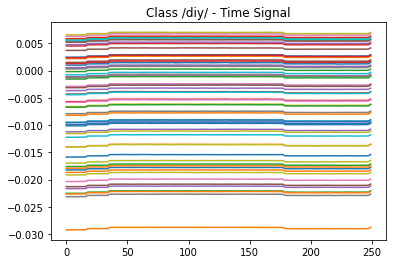

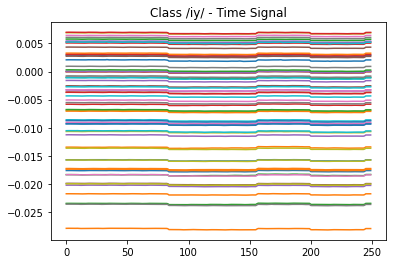

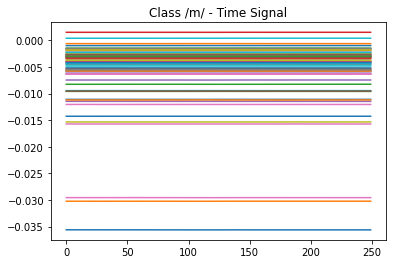

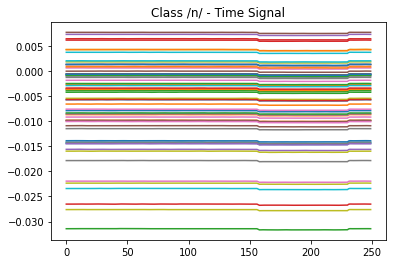

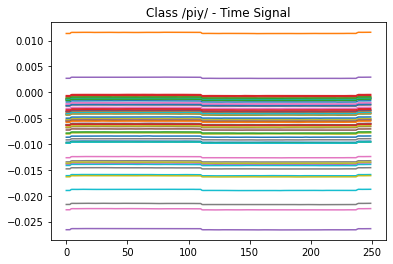

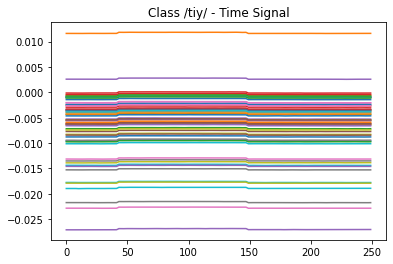

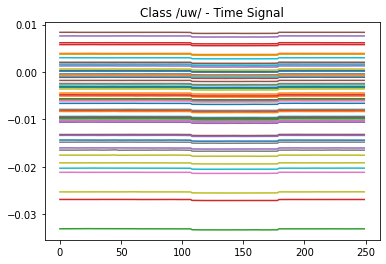

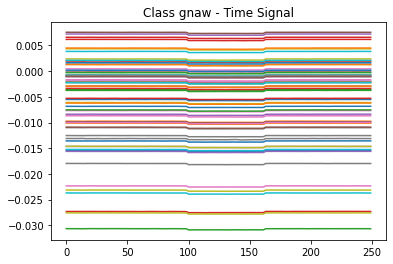

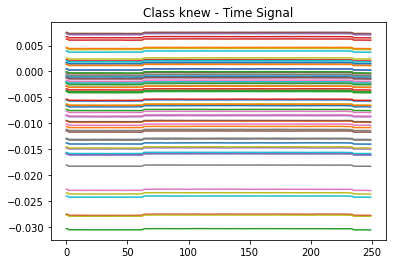

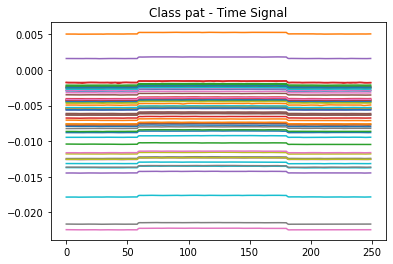

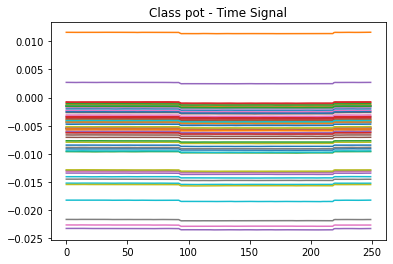

Train Shape: X (10712, 62, 250), Y (10712, 11)
Validation Shape: X (4592, 62, 250), Y (4592, 11)
Test Shape: X (15304, 62, 250), Y (15304, 11)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 250, 1)        35776     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 250, 1)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               4096128   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 11)    

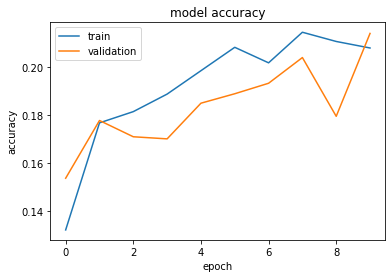

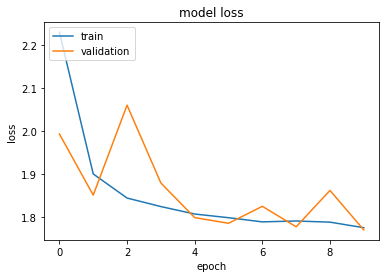

144/144 [==============================] - 0s 2ms/step


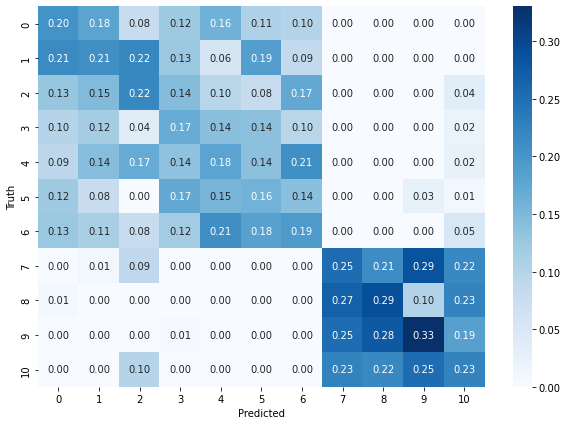

479/479 [==============================] - 1s 2ms/step
Kappa score: 0.07355543477828064
479/479 [==============================] - 1s 2ms/step
Balanced accuracy score: 0.15826094957649237
479/479 [==============================] - 1s 2ms/step
Recall score: 0.15826094957649237
479/479 [==============================] - 2s 4ms/step - loss: 3.2155 - accuracy: 0.1566
[3.2155191898345947, 0.15656037628650665]


In [ ]:
EPOCHS = 10
fe_time_signal = FeatureExtractor(
    all_trials,
    all_labels,
    run_fft=False,
    run_cov=False,
    run_normalize=False,
    output_shape=(1916*16, 62, 250),
)
X_train, X_val, X_test, y_train, y_val, y_test = fe_time_signal.get_data(
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx
)
fe_time_signal.plot_data(X_train)
del fe_time_signal
print(f"Train Shape: X {X_train.shape}, Y {y_train.shape}")
print(f"Validation Shape: X {X_val.shape}, Y {y_val.shape}")
print(f"Test Shape: X {X_test.shape}, Y {y_test.shape}")

cnn = CnnModel(
    (62, 250, 1),
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
)
print(cnn.model.summary())
cnn.fit(epochs=EPOCHS)
cnn.plot_train_val_accuracy()
cnn.plot_train_val_loss()
cnn.plot_confusion_matrix()
cnn.kappa_score()
cnn.balanced_accuracy_score()
cnn.recall_score()
print(cnn.evaluate())

# Time Signal Cross Covariance (62, 62) + CNN


<ipython-input-24-0f4c422e95e6>:79: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = figure.add_subplot(111)


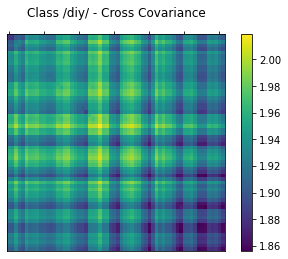

<ipython-input-24-0f4c422e95e6>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = figure.add_subplot(111)


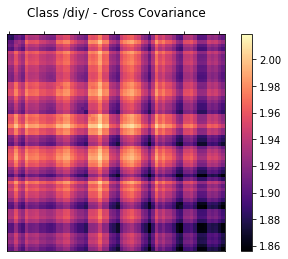

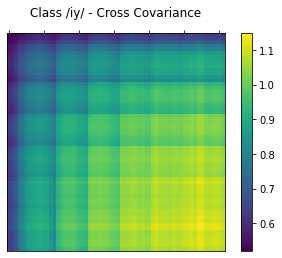

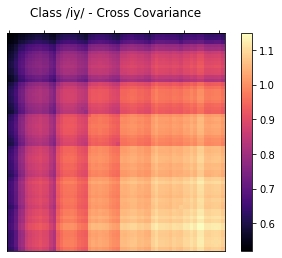

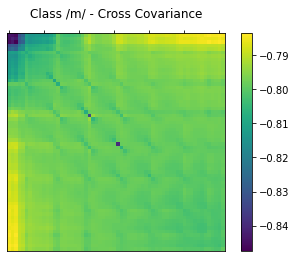

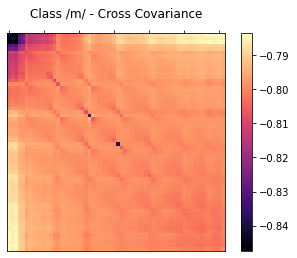

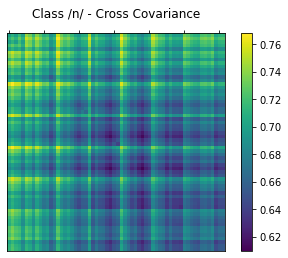

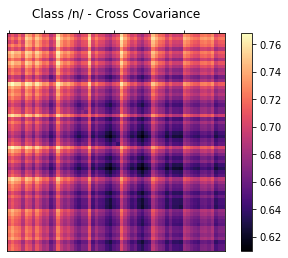

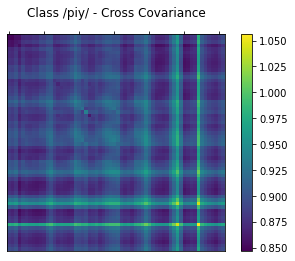

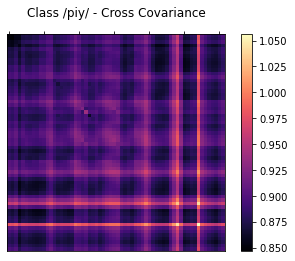

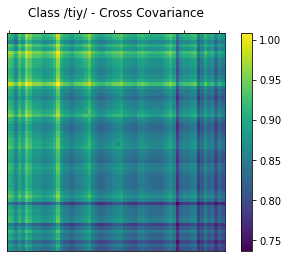

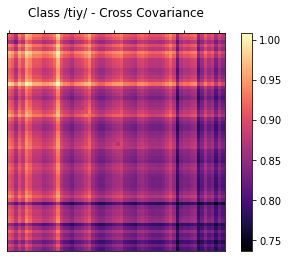

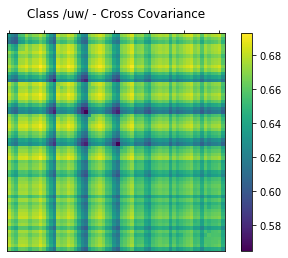

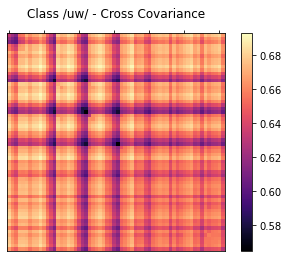

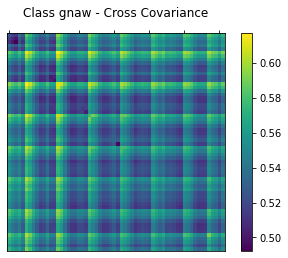

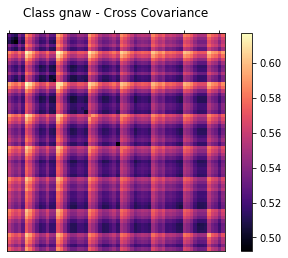

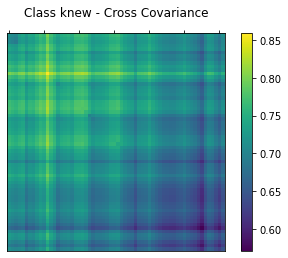

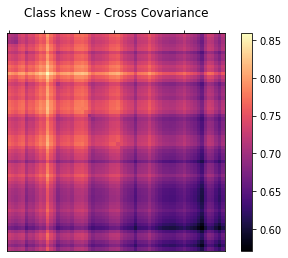

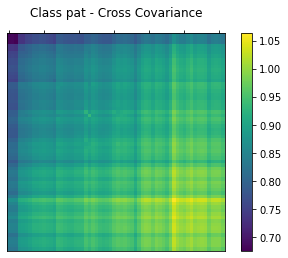

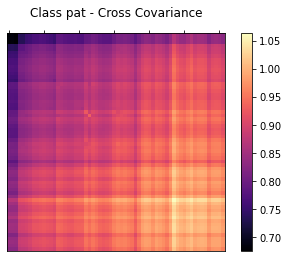

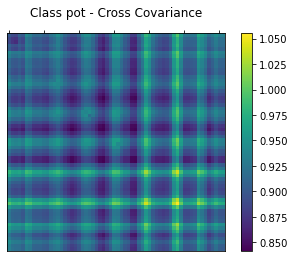

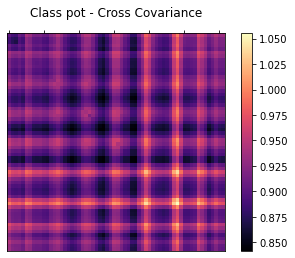





Train Shape: X (10712, 62, 62), Y (10712, 11)
Validation Shape: X (4592, 62, 62), Y (4592, 11)
Test Shape: X (15304, 62, 62), Y (15304, 11)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 conv2d_13 (Conv2D)          (None, 62, 62, 128)       73856     
                                                                 
 flatten_6 (Flatten)         (None, 492032)            0         
                                                                 
 dense_12 (Dense)            (None, 64)                31490112  
                                                                 
 dense_13 (Dense)            (None, 11)                715       
                                                                 
Total params: 31,565,323
Trainable params:

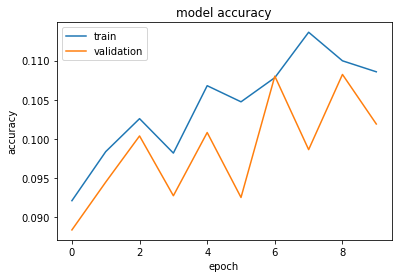

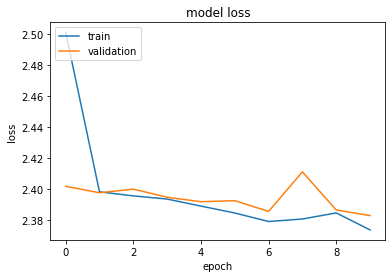

144/144 [==============================] - 1s 8ms/step


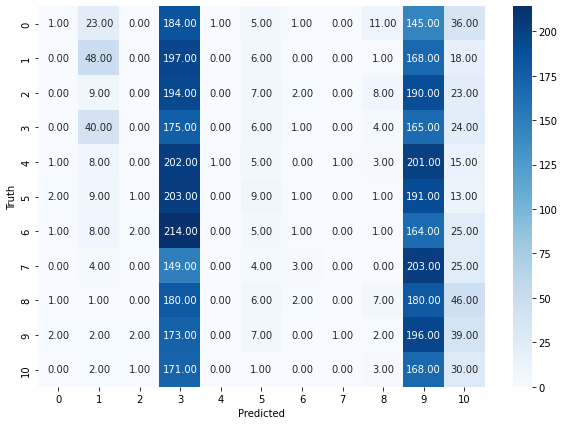

479/479 [==============================] - 4s 8ms/step
Kappa score: 0.0055784731809528365
479/479 [==============================] - 4s 8ms/step
Balanced accuracy score: 0.09609398834991224
479/479 [==============================] - 4s 8ms/step
Recall score: 0.09609398834991224
479/479 [==============================] - 4s 9ms/step - loss: 2.3982 - accuracy: 0.0961
Test Loss / Accuracy [2.3981614112854004, 0.09611865878105164]


In [ ]:
EPOCHS = 10
fe_time_signal_cov = FeatureExtractor(
    all_trials,
    all_labels,
    run_fft=False,
    run_cov=True,
    run_normalize=True,
    output_shape=(1916*16, 62, 62),
)
X_train, X_val, X_test, y_train, y_val, y_test = fe_time_signal_cov.get_data(
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx
)
fe_time_signal_cov.plot_data(X_train)
del fe_time_signal_cov
print(f"Train Shape: X {X_train.shape}, Y {y_train.shape}")
print(f"Validation Shape: X {X_val.shape}, Y {y_val.shape}")
print(f"Test Shape: X {X_test.shape}, Y {y_test.shape}")

cnn_time_cov = CnnModel(
    (62, 62, 1),
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
)
print(cnn_time_cov.model.summary())
cnn_time_cov.fit(epochs=EPOCHS)
cnn_time_cov.plot_train_val_accuracy()
cnn_time_cov.plot_train_val_loss()
cnn_time_cov.plot_confusion_matrix()
cnn_time_cov.kappa_score()
cnn_time_cov.balanced_accuracy_score()
cnn_time_cov.recall_score()
print("Test Loss / Accuracy", cnn_time_cov.evaluate())

# Frequency Signal Cross Covariance (62, 62) + CNN

<ipython-input-24-0f4c422e95e6>:79: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = figure.add_subplot(111)


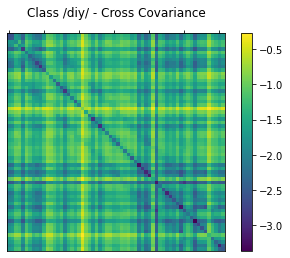

<ipython-input-24-0f4c422e95e6>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = figure.add_subplot(111)


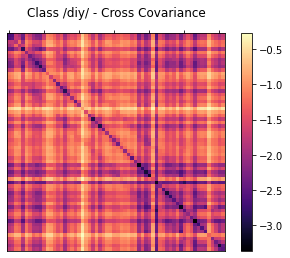

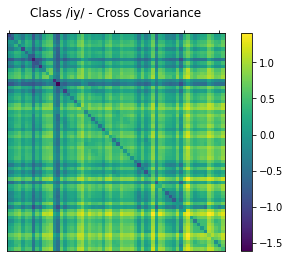

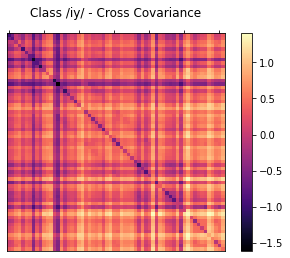

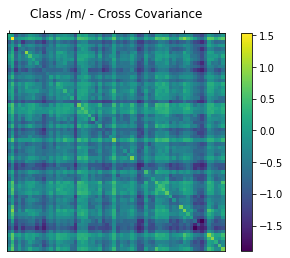

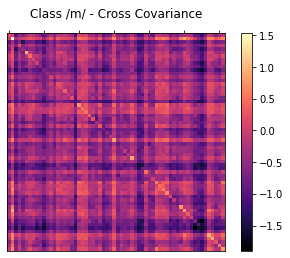

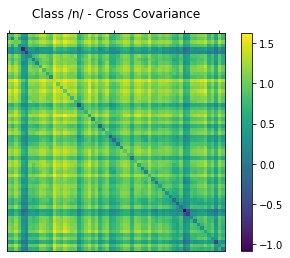

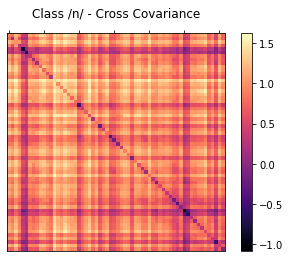

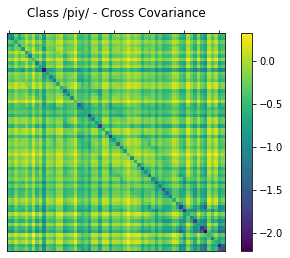

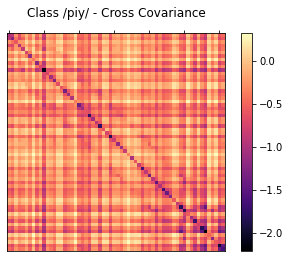

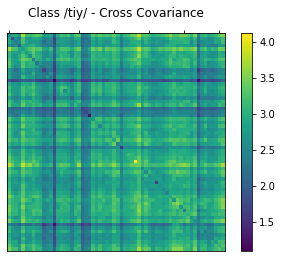

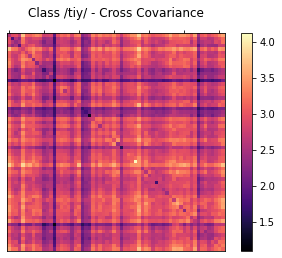

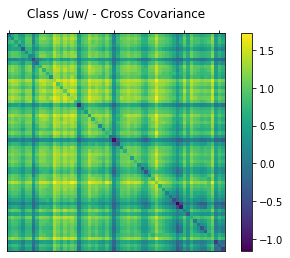

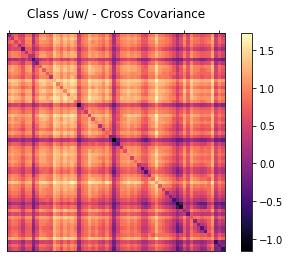

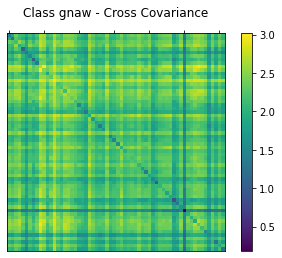

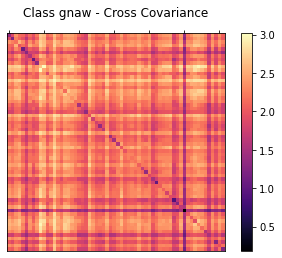

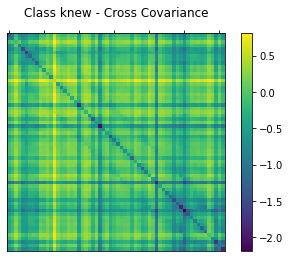

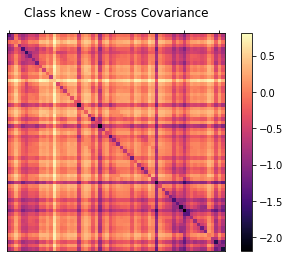

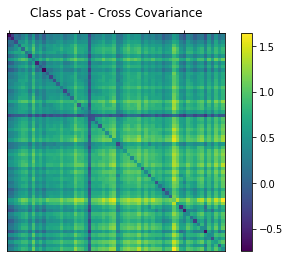

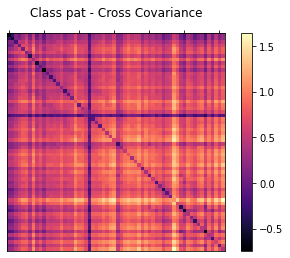

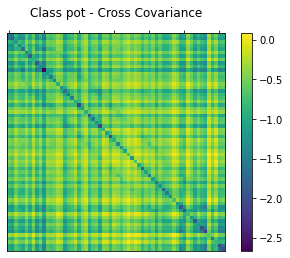

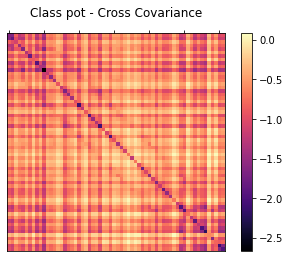





Train Shape: X (10712, 62, 62), Y (10712, 11)
Validation Shape: X (4592, 62, 62), Y (4592, 11)
Test Shape: X (15304, 62, 62), Y (15304, 11)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 conv2d_15 (Conv2D)          (None, 62, 62, 128)       73856     
                                                                 
 flatten_7 (Flatten)         (None, 492032)            0         
                                                                 
 dense_14 (Dense)            (None, 64)                31490112  
                                                                 
 dense_15 (Dense)            (None, 11)                715       
                                                                 
Total params: 31,565,323
Trainable params:

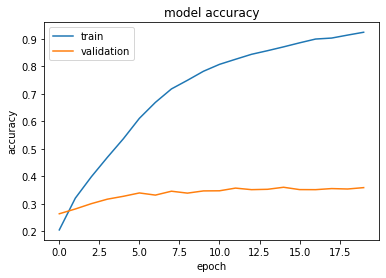

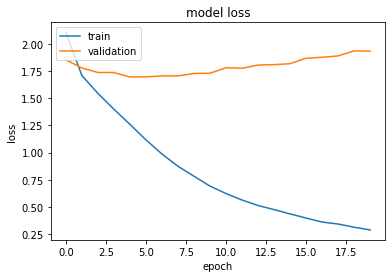

144/144 [==============================] - 1s 8ms/step


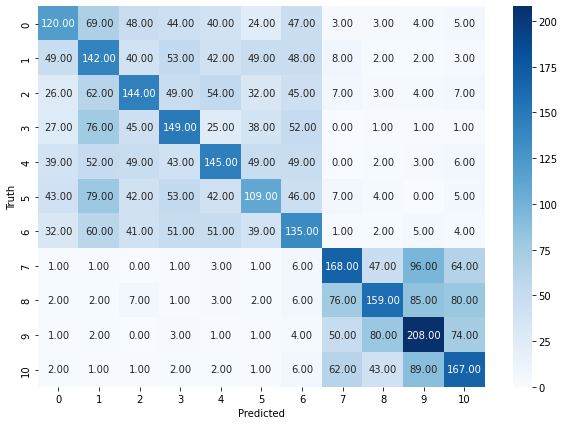

479/479 [==============================] - 4s 8ms/step
Kappa score: 0.376855667915164
479/479 [==============================] - 4s 8ms/step
Balanced accuracy score: 0.4335824573320833
479/479 [==============================] - 4s 8ms/step
Recall score: 0.4335824573320833
479/479 [==============================] - 4s 9ms/step - loss: 2.5953 - accuracy: 0.4334
Test Loss / Accuracy [2.595344066619873, 0.43341609835624695]


In [ ]:
EPOCHS = 20
fe_freq_cov = FeatureExtractor(
    all_trials,
    all_labels,
    run_fft=True,
    run_cov=True,
    run_normalize=True,
    output_shape=(1916*16, 62, 62),
)
X_train, X_val, X_test, y_train, y_val, y_test = fe_freq_cov.get_data(
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx
)
fe_freq_cov.plot_data(X_train)
del fe_freq_cov
print(f"Train Shape: X {X_train.shape}, Y {y_train.shape}")
print(f"Validation Shape: X {X_val.shape}, Y {y_val.shape}")
print(f"Test Shape: X {X_test.shape}, Y {y_test.shape}")

cnn_freq_cov = CnnModel(
    (62, 62, 1),
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
)
print(cnn_freq_cov.model.summary())
cnn_freq_cov.fit(epochs=EPOCHS)
cnn_freq_cov.plot_train_val_accuracy()
cnn_freq_cov.plot_train_val_loss()
cnn_freq_cov.plot_confusion_matrix()
cnn_freq_cov.kappa_score()
cnn_freq_cov.balanced_accuracy_score()
cnn_freq_cov.recall_score()
print("Test Loss / Accuracy", cnn_freq_cov.evaluate())

# Frequency Signal Cross Covariance (4, 62, 62) + CNN + LSTM

Train Shape: X (10712, 4, 62, 62), Y (10712, 11)
Validation Shape: X (4592, 4, 62, 62), Y (4592, 11)
Test Shape: X (15304, 4, 62, 62), Y (15304, 11)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 4, 62, 62, 64)     150016    
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 4, 62, 62, 128)    885248    
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 4, 62, 62, 64)     442624    
                                                                 
 flatten (Flatten)           (None, 984064)            0         
                                                                 
 dense (Dense)               (None, 64)                62980160  
                                                                 
 dense_1 (Dense)             (None, 11)

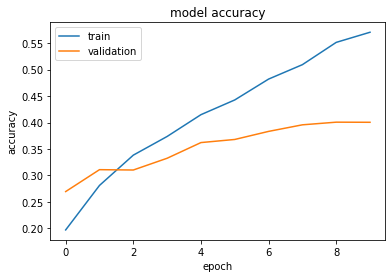

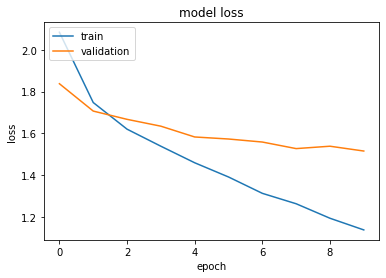

144/144 [==============================] - 54s 376ms/step


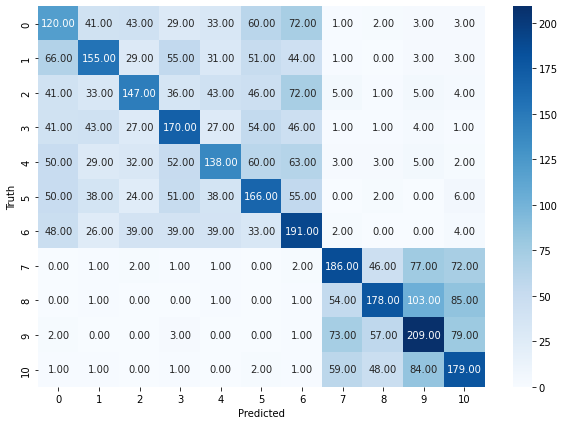

479/479 [==============================] - 183s 382ms/step - loss: 2.7458 - accuracy: 0.3324
[2.7458481788635254, 0.3323967456817627]


In [13]:
EPOCHS = 10
a= DataExtractor(1, 0, subjects, drop_ch)
framed_trials = a.create_frames(all_trials)
del all_trials, a
fe_freq_cov_frame = FeatureExtractor(
    framed_trials,
    all_labels,
    run_fft=True,
    run_cov=True,
    run_normalize=True,
    output_shape=(1916*16, 4, 62, 62),
    framed=True
)
X_train, X_val, X_test, y_train, y_val, y_test = fe_freq_cov_frame.get_data(
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx
)
del fe_freq_cov_frame
print(f"Train Shape: X {X_train.shape}, Y {y_train.shape}")
print(f"Validation Shape: X {X_val.shape}, Y {y_val.shape}")
print(f"Test Shape: X {X_test.shape}, Y {y_test.shape}")

cnn_freq_cov_lstm = CnnModel(
    (4, 62, 62, 1),
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
    model_type="cnn_lstm"
)
print(cnn_freq_cov_lstm.model.summary())
cnn_freq_cov_lstm.fit(epochs=EPOCHS)
cnn_freq_cov_lstm.plot_train_val_accuracy()
cnn_freq_cov_lstm.plot_train_val_loss()
cnn_freq_cov_lstm.plot_confusion_matrix()
cnn_freq_cov_lstm.kappa_score()
cnn_freq_cov_lstm.balanced_accuracy_score()
cnn_freq_cov_lstm.recall_score()
print("Test Loss / Accuracy", cnn_freq_cov_lstm.evaluate())

In [ ]:
cnn_freq_cov_lstm.kappa_score()
cnn_freq_cov_lstm.balanced_accuracy_score()
cnn_freq_cov_lstm.recall_score()

 32/479 [=>............................] - ETA: 2:44

# EEGNet

Train Shape: X (10712, 62, 250), Y (10712, 11)
Validation Shape: X (4592, 62, 250), Y (4592, 11)
Test Shape: X (15304, 62, 250), Y (15304, 11)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 62, 250, 1)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 250, 8)        512       
                                                                 
 batch_normalization_3 (Batc  (None, 62, 250, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 250, 16)       992       
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 250, 16)

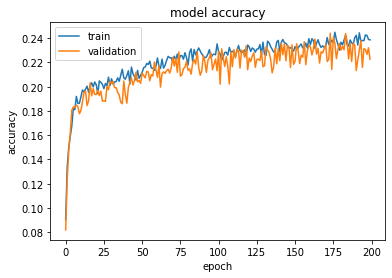

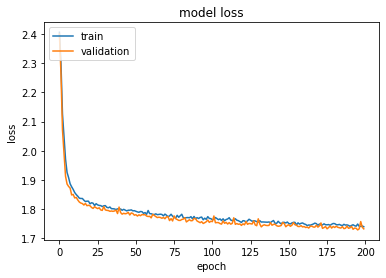

144/144 [==============================] - 0s 3ms/step


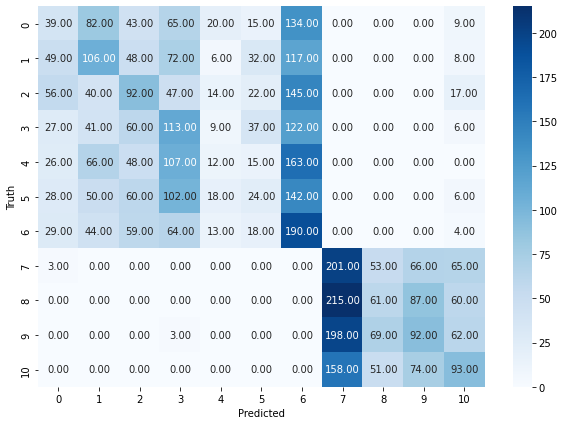

479/479 [==============================] - 1s 2ms/step
Kappa score: 0.08431542035086059
479/479 [==============================] - 1s 2ms/step
Balanced accuracy score: 0.16768930281805441
479/479 [==============================] - 1s 2ms/step
Recall score: 0.16768930281805441
479/479 [==============================] - 2s 4ms/step - loss: 6.0868 - accuracy: 0.1673
[6.086777210235596, 0.16734187304973602]


In [ ]:
EPOCHS = 200
fe = FeatureExtractor(
    all_trials,
    all_labels,
    run_fft=False,
    run_cov=False,
    run_normalize=False,
    output_shape=(1916*16, 62, 250),
)
X_train, X_val, X_test, y_train, y_val, y_test = fe.get_data(
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx
)
# fe_freq_cov.plot_data(X_train)
del fe
print(f"Train Shape: X {X_train.shape}, Y {y_train.shape}")
print(f"Validation Shape: X {X_val.shape}, Y {y_val.shape}")
print(f"Test Shape: X {X_test.shape}, Y {y_test.shape}")

cnn_eegnet = CnnModel(
    (62, 250, 1),
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
    model_type="eegnet"
)
print(cnn_eegnet.model.summary())
cnn_eegnet.fit(epochs=EPOCHS)
cnn_eegnet.plot_train_val_accuracy()
cnn_eegnet.plot_train_val_loss()
cnn_eegnet.plot_confusion_matrix()
cnn_eegnet.kappa_score()
cnn_eegnet.balanced_accuracy_score()
cnn_eegnet.recall_score()
print(cnn_eegnet.evaluate())